In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-10000-popular-movies/Top_10000_Movies.csv


In [2]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import spacy
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('/kaggle/input/top-10000-popular-movies/Top_10000_Movies.csv',lineterminator='\n')
data.head()

,Unnamed: 0,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,0,580489,en,Venom: Let There Be Carnage,5401.308,2021-09-30,6.8,1736,"['Science Fiction', 'Action', 'Adventure']",After finding a host body in investigative rep...,424000000,97.0,NaN
1,1,524434,en,Eternals,3365.535,2021-11-03,7.1,622,"['Action', 'Adventure', 'Science Fiction', 'Fa...",The Eternals are a team of ancient aliens who ...,165000000,157.0,In the beginning...
2,2,438631,en,Dune,2911.423,2021-09-15,8.0,3632,"['Action', 'Adventure', 'Science Fiction']","Paul Atreides, a brilliant and gifted young ma...",331116356,155.0,"Beyond fear, destiny awaits."
3,3,796499,en,Army of Thieves,2552.437,2021-10-27,6.9,555,"['Action', 'Crime', 'Thriller']",A mysterious woman recruits bank teller Ludwig...,0,127.0,"Before Vegas, one locksmith became a legend."
4,4,550988,en,Free Guy,1850.470,2021-08-11,7.8,3493,"['Comedy', 'Action', 'Adventure', 'Science Fic...",A bank teller called Guy realizes he is a back...,331096766,115.0,Life's too short to be a background character.


In [4]:
data.shape

(10000, 13)

In [5]:
usecols=['id','original_title','genre','overview','tagline']
data_use=data[usecols]
data_use=data_use.dropna(subset=['overview'])

In [6]:
data_use.replace(np.nan,"",regex=True,inplace=True)

In [7]:
data_use.head()

,id,original_title,genre,overview,tagline
0,580489,Venom: Let There Be Carnage,"['Science Fiction', 'Action', 'Adventure']",After finding a host body in investigative rep...,
1,524434,Eternals,"['Action', 'Adventure', 'Science Fiction', 'Fa...",The Eternals are a team of ancient aliens who ...,In the beginning...
2,438631,Dune,"['Action', 'Adventure', 'Science Fiction']","Paul Atreides, a brilliant and gifted young ma...","Beyond fear, destiny awaits."
3,796499,Army of Thieves,"['Action', 'Crime', 'Thriller']",A mysterious woman recruits bank teller Ludwig...,"Before Vegas, one locksmith became a legend."
4,550988,Free Guy,"['Comedy', 'Action', 'Adventure', 'Science Fic...",A bank teller called Guy realizes he is a back...,Life's too short to be a background character.


In [8]:
data_use['overview']=data_use['overview'].apply(lambda x:x.lower())
data_use['genre']=data_use['genre'].apply(lambda x:x.lower())
data_use['tagline']=data_use['tagline'].apply(lambda x:x.lower())

data_use['genre']=data_use['genre'].str.replace(r"[\"\',]", '',regex=True)
     
df=pd.DataFrame({'id':data_use['id'],
                'original_title':data_use['original_title'],
                'features':data_use['genre']+data_use['overview']+data_use['tagline']})
df.head()

,id,original_title,features
0,580489,Venom: Let There Be Carnage,[science fiction action adventure]after findin...
1,524434,Eternals,[action adventure science fiction fantasy]the ...
2,438631,Dune,[action adventure science fiction]paul atreide...
3,796499,Army of Thieves,[action crime thriller]a mysterious woman recr...
4,550988,Free Guy,[comedy action adventure science fiction]a ban...


In [9]:
df['tokenized']=df['features'].apply(lambda x: word_tokenize(x))

In [10]:
stop_words=set(stopwords.words('english'))
df['clean']=df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words and word!=' ' and word not in string.punctuation])

In [11]:
df.head()

,id,original_title,features,tokenized,clean
0,580489,Venom: Let There Be Carnage,[science fiction action adventure]after findin...,"[[, science, fiction, action, adventure, ], af...","[science, fiction, action, adventure, finding,..."
1,524434,Eternals,[action adventure science fiction fantasy]the ...,"[[, action, adventure, science, fiction, fanta...","[action, adventure, science, fiction, fantasy,..."
2,438631,Dune,[action adventure science fiction]paul atreide...,"[[, action, adventure, science, fiction, ], pa...","[action, adventure, science, fiction, paul, at..."
3,796499,Army of Thieves,[action crime thriller]a mysterious woman recr...,"[[, action, crime, thriller, ], a, mysterious,...","[action, crime, thriller, mysterious, woman, r..."
4,550988,Free Guy,[comedy action adventure science fiction]a ban...,"[[, comedy, action, adventure, science, fictio...","[comedy, action, adventure, science, fiction, ..."


In [12]:
stemmer=PorterStemmer()
df['stem']=df['clean'].apply(lambda x: [stemmer.stem(word) for word in x])

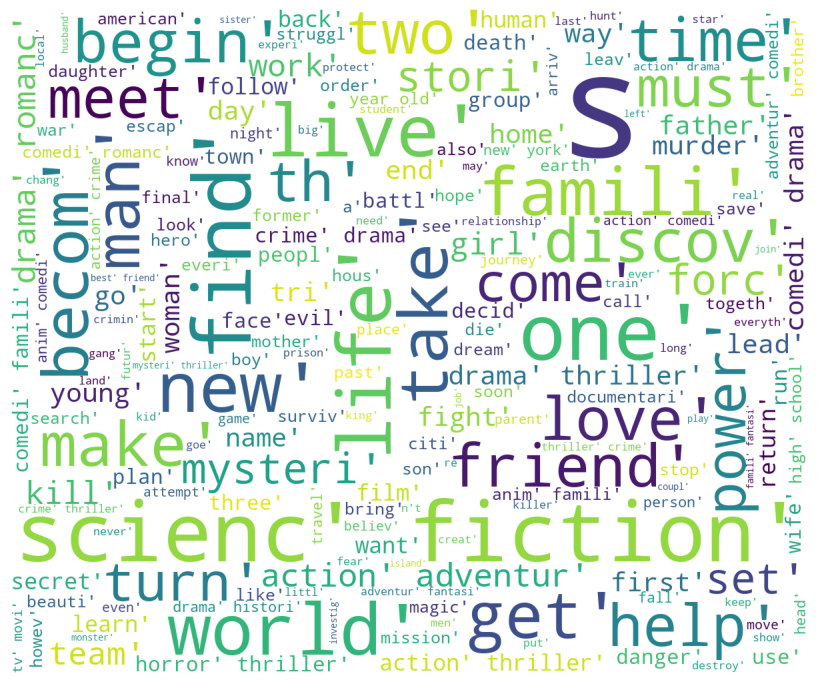

In [13]:
from wordcloud import WordCloud

words=[word for words in df['stem'] for word in words ]

wordcloud = WordCloud(width = 1200, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(str(words))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [14]:
def list_to_str(l):
    st=''
    for word in l:
        st+=word+' '
    return st

In [15]:
df['final']=df['stem'].apply(lambda x: list_to_str(x))

In [16]:
tfidf=TfidfVectorizer()
vector=tfidf.fit_transform(df['final']).toarray()

In [17]:
similarity=cosine_similarity(vector)

In [18]:
def recommend(movie):
    index=df[df['original_title']==movie].index[0]
    distances=similarity[index]
    recos=sorted(enumerate(distances),reverse=True,key=lambda x:x[1])[1:6]

    for movie in recos:
        print(df['original_title'][movie[0]])

In [19]:
recommend('The Game')

Diablo
Overdrive
The Change-Up
7 Guardians of the Tomb
Le Porno Killers


In [20]:
new=pd.DataFrame({'movie_id':df['id'],
                    'title':df['original_title'],
                    'tags':df['final']})
new.head()

,movie_id,title,tags
0,580489,Venom: Let There Be Carnage,scienc fiction action adventur find host bodi ...
1,524434,Eternals,action adventur scienc fiction fantasi etern t...
2,438631,Dune,action adventur scienc fiction paul atreid bri...
3,796499,Army of Thieves,action crime thriller mysteri woman recruit ba...
4,550988,Free Guy,comedi action adventur scienc fiction bank tel...


In [21]:
import pickle
pickle.dump(new,open('movie_list.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))